# Read raw data

In [37]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# Read ground truth values for all 500k images
ground_truth = np.genfromtxt('gt_train.csv', delimiter=',', dtype=['u4', 'U50'])

# Put image titles and their labels in a dictionary for easy retrieval
# Format: [imageNumber:Label]. Ex: [43123:'pedestrian']

gt = {}
for img in ground_truth:
    gt[img[0]] = img[1]

# Load 1000 grey images from each catagory and put them in the lists below
images = []
names = []
labels = []
for f in glob.glob("MIO-TCD-Classification/train/*"):
    s=0
    for g in glob.glob(str(f)+'/*.jpg'):
        img = cv2.imread(g, 0) # Read image in grey
        name = int(g[-12:-4]) # File name
        images.append(img)
        names.append(name)
        labels.append(gt[name])
        s += 1
        if (s == 1000):
            break
print(len(images), len(labels), len(names))

MIO-TCD-Classification/train/background
MIO-TCD-Classification/train/car
MIO-TCD-Classification/train/articulated_truck
MIO-TCD-Classification/train/non-motorized_vehicle
MIO-TCD-Classification/train/motorcycle
MIO-TCD-Classification/train/bus
MIO-TCD-Classification/train/pedestrian
MIO-TCD-Classification/train/single_unit_truck
MIO-TCD-Classification/train/bicycle
MIO-TCD-Classification/train/work_van
MIO-TCD-Classification/train/pickup_truck
11000 11000 11000


471032 bus


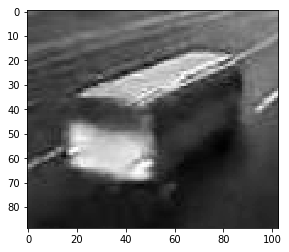

# HoG Features

In [40]:
# Function to compute hog features
def hog(img):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[0], block_size[1], nbins) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
    
    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

# Compute HoG Features

In [41]:
# Now the images are of diffrent sizes. We might need to fill the smaller images with zeros
def fill(arr, max_len):
    x = np.zeros(abs(len(arr) - max_len))
    return np.concatenate((arr,x), axis=0)

hogs_temp = []
#calculate hog for each image
max_len = 0
avg = 0
for image in images:
    #the classifier takes 2d training data. hog produces 3d so we flatten the result to make it 1d.. then we
    #group all hogs in one list to make a 2d list
    
    # [REVEIW] resize because knn expects all data to be symetric
    grad = hog(cv2.resize(image, (50, 50))).flatten()
#     grad = hog(image).flatten()
    avg += len(grad)
    if len(grad) > max_len:
        max_len = len(grad)
    hogs_temp.append(grad)

#convert the HoGs array to np array to be processed
hogs_temp = np.array(hogs_temp)
hogs = hogs_temp

# In case we need to fill the smaller images with zeros. For now we just resize them
# hogs = []
# more = 0
# less = 0
# for h in hogs_temp:
#     if len(h) > avg/len(images):
#         more += 1
#     else:
#         less += 1
#     new = fill(h,max_len)
#     hogs.append(new)
# hogs = np.array(hogs)

print('Shape of the hogs list: ',hogs.shape, max_len)

Shape of the hogs list:  (11000, 1152) 1152


0.0 1152.0


/Users/Aljulanda/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/Aljulanda/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/Aljulanda/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


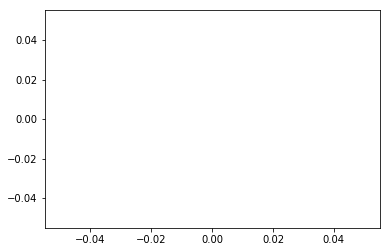

In [42]:
# Just to see the distrbution of the lenghts of the flat hogs (maybe we can filter out stuff)
# ONLY WORKS IF WE ARE NOT RESIZING
from scipy import stats
h = []
for ho in hogs:
    h.append(len(ho))
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf) # including h here is crucial
print(hstd, hmean)

# Split data and Classify using KNN and SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import  train_test_split 
from sklearn.neighbors import KNeighborsClassifier as knc

X_train, X_test, y_train, y_test = train_test_split(hogs, labels, test_size=0.25)

########################################################
## KNN CLASSIFIER
knn = knc(n_neighbors = 3)

knn.fit(X_train, y_train)

p = knn.predict(X_test)

# Measure accuracy
# IT'S NOT ACCURATE BECAUSE WE RESIZE IMAGES.. FIND A WAY TO FIT WITHOUT RESIZING
i = 0
for x in range(len(p)):
    if p[x] == y_test[x]:
        i += 1
print('Accuracy of KNN is', i, 'out of', len(X_test), ', percentage: %', 100*i/len(X_test))
########################################################


########################################################
## SVM CLASSIFIER
# https://scikit-learn.org/stable/modules/svm.html

# Create svm Linear object
lin_clf = svm.LinearSVC()

lin_clf.fit(X_train, y_train)

p_svm = lin_clf.predict(X_test)

# Accuracy
k = 0
for x in range(len(p)):
    if p_svm[x] == y_test[x]:
        k += 1
print('Accuracy of SVM is', k, 'out of', len(X_test), ', percentage: %', 100*k/len(X_test))
########################################################